# HashCanon Specification

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import pandas as pd
import sys
sys.path.append("..")

import importlib
import hash_utils.base_hash as base_hash
importlib.reload(base_hash)
print()

## Content

- Introduction
- 1. Hash and Randomness
- 2. Binary Representation of Numbers and the Schemes of the “Book of Changes”
- 3. The Principle of Diagram Construction
- 4. Features of Order
  - 4.1 Balanced Mandala
  - 4.2 Passages and Sealed Structures in the Mandala
    - 4.2.1 Single-Passage Hash
    - 4.2.2 Determining the Number of Passages in a Mandala Generated from a Random Hash
    - 4.2.3 Sealed Mandala
    - 4.2.4 Distribution of Passage Counts
  - 4.3 Symmetries (Circular Palindromes)
    - 4.3.1 Summary metric
    - 4.3.2 Symmetry list (positions and slices)
    - 4.3.3 Rank aggregation
    - 4.3.4 Overlay data
    - 4.3.5 Crown (maximum symmetry)
    - 4.3.6 Crown summary metric
    - 4.3.7 Distribution of Symmetries
- 5. Simulated Joint Distribution
  - 5.1 Aggregations: Passages × Balance
  - 5.2 Symmetry metrics on the same sample (N = 8,192; 256-bit)
    - 5.2.1 Passages × Symmetries (means, medians, tails)
    - 5.2.2 Balanced vs Non-balanced: Symmetries & Passages
    - 5.2.3 Contingency: num_passages × max_rank
- Community & Support

## Introduction

**HashCanon** is a philosophical and aesthetic experiment at the intersection of generative art, cryptography, and East Asian symbolism. The name blends **“hash”** (a unique digital fingerprint) with the notion of a **canon**—a structured body of knowledge that renders order from multiplicity.

A full **256-bit hash** is rendered as a **mandala of 64 radial sectors and 4 concentric layers**: one hex symbol → one sector, one bit → one layer.
For cases where only **160 bits** are available—such as Ethereum wallet or contract addresses—HashCanon shortens the circle to **40 sectors** while keeping the same 4-ring logic. Both sizes are derived from the same 256-bit mapping, so the visual grammar stays consistent.

This transformation of number into image raises questions: Can randomness become meaningful? What if we treat digital structures as modern ideograms? Where is the boundary between entropy and canon? References to the 64 hexagrams of *the I Ching* and the Daoist diagram **Wújí → Tàijí** (无极 → 太极) connect this inquiry to an ancient tradition of contemplating change.

All functions used throughout this notebook are collected in a single module:
[**`base_hash.py`**](https://github.com/HashCanon/hashcanon/blob/main/hash_utils/base_hash.py) — the central utility library for hash generation, bit manipulation, mandala construction, and feature extraction.

**Definition. Circular bit matrix (“mandala”).**
In HashCanon, any 256-bit hash is represented as a **64×4 circular bit matrix**: 64 radial sectors and 4 concentric rings. **1 hex character → 1 sector**, **1 bit → 1 ring cell** (from center outward: least-significant → most-significant).
For 160-bit data (Ethereum addresses) we use the same grammar with **40 sectors × 4 rings**.
For brevity, we refer to this structure as a **“mandala.”**

### Glossary (HashCanon)

* **Circular bit matrix (mandala)** — a visual representation of a hash as a circle with **64 (or 40)** sectors and **4** rings; each sector encodes one hex character (4 bits), rings encode the bits within that character.
* **Balanced** — an even-length hash **n** with exactly **n/2** ones and **n/2** zeros (for 256 bits: 128/128; for 160 bits: 80/80).
* **Passage** — a **connected path** of **0-cells** (black) linking the **inner** ring to the **outer** ring. **Sealed** — a mandala with **no** passages (passage count = 0).
* **Symmetries (circular palindromes)** — contiguous arcs of length **≥ 2** where **across all four rings** bits read the same left-to-right and right-to-left **with wraparound**. We retain only **maximal** (non-nested) palindromes.
* **Rank** — the length of a palindrome arc in sectors (e.g., rank = 3 means three adjacent sectors).
* **Symmetry ranks** — a `rank:count` map that aggregates how many palindromes of each rank are present in a mandala.
* **Crown** — a short symmetry signature **`R:C`**, where **R** is the maximum rank in the mandala and **C** is how many **maximal** palindromes of that rank occur. If there are none, use **`—`**.
* **Evenness** — the share of ones (or the white/black ratio) in the bit string.
* **Sectors / Rings** — geometric elements of the mandala: **sectors** go around the circle (64 or 40), **rings** are the 4 concentric levels from center to edge.


## 1. Hash and Randomness

### What is a Hash?

A **hash function** is a mathematical transformation that takes an input (a string, file, or data block) and produces a fixed-length fingerprint — typically 256 or 160 bits.

Key characteristics:

* It is **one-way**: it's easy to compute a hash from an input, but practically impossible to recover the input from the hash;
* It is **collision-resistant**: it’s extremely unlikely that two different inputs will produce the same hash;
* It is **sensitive to input changes**: even a single altered character will completely change the output.

Hashes are widely used in cryptography, blockchain systems (e.g., Bitcoin, Ethereum), digital signatures, and data verification.

In **HashCanon**, hashes are not just cryptographic primitives — they serve as raw material for visual pattern generation. By treating each bit as a building block of form, the system transforms invisible entropy into visible structure.

You can generate a 256-bit or 160-bit hash from any string (e.g., `"HashCanon"`) using the functions provided in the utility module [**base_hash.py**](https://github.com/HashCanon/hashcanon/blob/main/hash_utils/base_hash.py).

In [243]:
print(f"➜ SHA-256 (default): {base_hash.hash_to_hex('HashCanon')}")
print(f"➜ SHA-256, truncated: {base_hash.hash_to_hex('HashCanon', bits=160)}")
print(f"➜ Ethereum-style Keccak-256: {base_hash.hash_to_hex('HashCanon', algo='keccak')}")
print(f"➜ Ethereum address (last 20 bytes of Keccak-256): {base_hash.hash_to_hex('HashCanon', bits=160, algo='keccak')}")

➜ SHA-256 (default): 0xa403e93f2190a97c22b4c161e89b820c49bbcc5ffd76d0ffef67483d7c41b530
➜ SHA-256, truncated: 0xe89b820c49bbcc5ffd76d0ffef67483d7c41b530
➜ Ethereum-style Keccak-256: 0x23e3e8374780b3ac8a1f8bfad227acd007303a00ea51f189dd61316fe9de8428
➜ Ethereum address (last 20 bytes of Keccak-256): 0xd227acd007303a00ea51f189dd61316fe9de8428


### On Randomness and Security

The function `base_hash.generate_random_hash()` **relies on cryptographically secure pseudorandom number generators (CSPRNGs)**, so every output is *statistically indistinguishable from true randomness*.

* With `algo="sha256"`, entropy is **sourced with** `secrets.token_hex()`, which draws from the operating system’s CSPRNG (e.g., `/dev/urandom` on Unix-like systems).
* With `algo="keccak"`, entropy bytes are **fed into** the Keccak-256 sponge, yielding a deterministic digest from a high-entropy seed. **Keccak** is the winner of the SHA-3 competition; note that Ethereum’s `keccak256` differs slightly from NIST `SHA3-256` (padding).

Although the digest function is deterministic **given a fixed seed**, the outputs of a CSPRNG remain **computationally unpredictable unless the generator’s internal state is known**, which makes this pipeline suitable for cryptographic as well as generative-art applications.

### Hash in HashCanon

In the generative system **HashCanon**, everything begins with a **cryptographic hash** — typically a **256-bit value** rendered as 64 hexadecimal characters (often shown with `0x` prefix). Each hash serves as a unique seed for visual generation.

Cryptographic hashes possess two essential properties:

* **Determinism** — the same input always produces the same output;
* **Apparent randomness** — even a tiny change in input leads to an unpredictable, drastically different result.

This combination makes the hash an ideal bridge between number and image: it guarantees repeatability while preserving complexity and surprise.

In practice, HashCanon supports:

* **256-bit hashes** (default, e.g., SHA-256 or Keccak-256);
* **160-bit view**, which yields 40-sector mandalas — analogous in length to Ethereum addresses.
  *Implementation note:* the 160-bit view is a **truncation of the 256-bit digest** (choose a canonical policy, e.g., “take the first 160 bits”).
* **Keccak-256** (Ethereum-style `keccak256`) for Web3-native compatibility.

### Hash generation from text

In **HashCanon**, you can derive a cryptographic hash from any input string—whether it’s a meaningful phrase, a wallet address, or an emblematic word—and immediately turn that hash into a visual pattern. For example:

In [244]:
hash_hex = base_hash.hash_to_hex('HashCanon')
print(hash_hex)

0xa403e93f2190a97c22b4c161e89b820c49bbcc5ffd76d0ffef67483d7c41b530


This command produces a **256-bit SHA-256 hash** from the input `“HashCanon“`. The result is a hexadecimal string that can be directly used to generate a mandala:

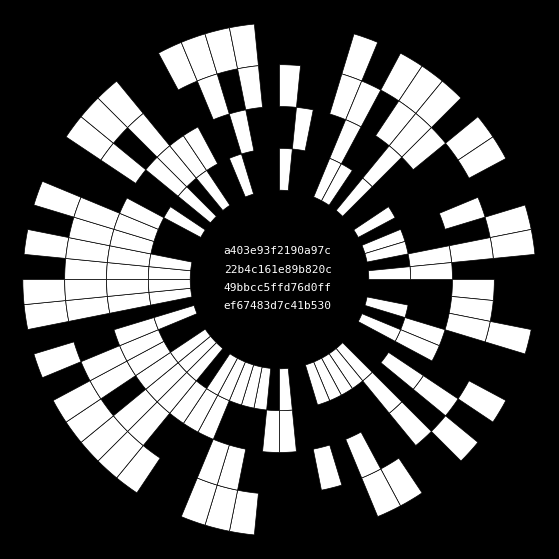

Figure 1. Mandala of the SHA-256 hash for “HashCanon“: 0xa403e93f2190a97c22b4c161e89b820c49bbcc5ffd76d0ffef67483d7c41b530



In [245]:
base_hash.draw_mandala(hash_hex)
print(f'Figure 1. Mandala of the SHA-256 hash for “HashCanon“: {hash_hex}\n')

> **Note:** The geometric rules behind this circular mandala—how bits map to rings and sectors—are outlined only briefly here. A complete, step-by-step explanation is presented in the following sections.

You can also specify the bit length or algorithm:

In [246]:
print(f"➜ 160-bit SHA-256-derived hash: {base_hash.hash_to_hex('HashCanon', bits=160)}")
print(f"➜ Ethereum-style Keccak-256 hash: {base_hash.hash_to_hex('HashCanon', algo='keccak')}")

➜ 160-bit SHA-256-derived hash: 0xe89b820c49bbcc5ffd76d0ffef67483d7c41b530
➜ Ethereum-style Keccak-256 hash: 0x23e3e8374780b3ac8a1f8bfad227acd007303a00ea51f189dd61316fe9de8428


This allows full flexibility in generating deterministic, symbolically meaningful mandalas from text.

### Why SHA-256?

We use **SHA-256** (Secure Hash Algorithm, 256-bit) because it is:

* **Widely adopted** and battle-tested in security, storage, and many blockchain contexts (e.g., Bitcoin; numerous protocols and libraries).
* Produces a **fixed 256-bit output** (64 hex characters), which maps naturally to our **4 × 64** bit mandala grid.
* **Neutral and portable**: it provides a reliable default for off-chain and cross-chain use, while **Keccak-256** is available for Ethereum-native parity.

While other algorithms exist (SHA-1, SHA-3, BLAKE2, RIPEMD-160), SHA-256 remains a de facto standard for secure, verifiable entropy and for reproducible generative pipelines.

> **Ethereum note.** Ethereum uses **Keccak-256** (often referred to as `keccak256`), which is slightly different from NIST **SHA3-256** due to padding. Our default is SHA-256 for neutrality; Keccak-256 is supported as an option for Web3-native workflows.

The resulting 64 hex characters are read as 256 bits → **64 radial sectors × 4 concentric layers** in the HashCanon visualization (1 hex → 1 sector, 1 bit → 1 ring). Thus every hex occupies a unique radial slice, and its 4 bits stack as four concentric rings inside that slice. The full mapping is detailed in the next sections.

### Where to Get Hashes in the Blockchain

| Source                                 | Usage in NFT minting / pipelines                                 | Size                |
| -------------------------------------- | ---------------------------------------------------------------- | ------------------- |
| `tokenData.hash` (Art Blocks)          | Auto-assigned per token; used as a seed in generative projects   | 256 bits (32 bytes) |
| `blockhash(n)`                         | Block-scoped seed; usable only for **recent blocks**             | 256 bits (32 bytes) |
| `keccak256(tokenId ∥ secret)`          | Deterministic seed with user salt (on-/off-chain)                | 256 bits (32 bytes) |
| `sha256`, `blake2b`, Poseidon, Rescue… | Off-chain hashing; zk-friendly options for SNARK/STARK pipelines | Typically 256 bits  |

> **Caveat:** `blockhash(n)` returns zero for **old blocks** (beyond the recent window) and is observable/manipulable within miner/validator constraints; don’t treat it as unpredictable randomness for adversarial settings.

#### Deterministic Randomness as a Mirror of Form

Hashes turn invisible entropy into visible order. The mandala reveals hidden symmetries, rhythms, and repetitions latent in raw bits — the *yīn–yáng* of digital entropy at the heart of **HashCanon**.

## 2. Binary Representation of Numbers and the Schemes of the “Book of Changes”

The *I Ching* (易經, *Yìjīng*) — the “Book of Changes” — is arguably the first known example of **binary notation** in human history.
Its “alphabet” is the **hexagram**: a vertical stack of 6 lines, where

| Line   | Symbol | Bit | Semantics                     |
| ------ | ------ | --- | ----------------------------- |
| broken | — —    | 0   | 陰 *yīn* — darkness, passivity |
| solid  | ——     | 1   | 陽 *yáng* — light, activity    |

Each hexagram is thus encoded as a number **from 0 to 63** (2⁶ = 64 combinations). The **least significant bit** is the **top** line, the **most significant** is the **bottom**.

| Line index | 0 (000000) | 1 (000001) | 2 (000010) |  …  | 62 (111110) | 63 (111111) |
| :--------: | :--------: | :--------: | :--------: | :-: | :---------: | :---------: |
|      ⑥     |     — —    |     ——     |     — —    |     |     — —     |      ——     |
|      ⑤     |     — —    |     — —    |     ——     |     |      ——     |      ——     |
|      ④     |     — —    |     — —    |     — —    |     |      ——     |      ——     |
|      ③     |     — —    |     — —    |     — —    |     |      ——     |      ——     |
|      ②     |     — —    |     — —    |     — —    |     |      ——     |      ——     |
|      ①     |     — —    |     — —    |     — —    |     |      ——     |      ——     |

**Table.** Vertical bit layouts for hexagrams in binary order. Rows ⑥ → ① represent lines from **top** (least significant bit) to **bottom** (most significant); columns show the first three and last two hexagrams of the 0–63 range. `——` denotes a *yáng* line (1), `— —` a *yīn* line (0); `…` indicates omitted intermediate columns.

![Circular arrangement of 64 hexagrams](pic/yi_circle.jpg)

**Figure 2.** Circular arrangement of the 64 hexagrams (binary order)

**Circular diagram of the 64 hexagrams in ascending binary order.**
The starting point is **Kūn** `000000` at the top. Moving clockwise, we add **1** to the six-bit number with each step: `000001`, `000010`, … until the cycle closes at **Qián** `111111`. Black = *yīn* (0), white = *yáng* (1).
This **ascending order** matches the way HashCanon fills its 64 sectors.

### From Hexagrams to HashCanon

HashCanon takes the same idea of binary motifs and applies it to a modern **256-bit hash** (SHA-256 / Keccak-256):

```
0x87a797a48cba94ee585ee2c0d7d6f4cce4dd12f77192a4d0bc562938d6fb62b1
```

* 64 hex characters → **64 sectors** of the mandala;
* each hex = 4 bits → **4 concentric layers** (from center to periphery).

Thus emerges a natural bridge between cryptographic randomness and the binary cosmology of the *I Ching*: instead of six stacked lines we now read four nested rings, yet the mapping **“least significant bit → innermost layer”** mirrors the classical idea that genesis starts at the base and unfolds outward.

## 3. The Principle of Diagram Construction

HashCanon interprets a 256-bit hash as **64 hexadecimal characters**.
Each hex character → **4 bits** → one radial sector with **4 concentric cells**.

### ▸ Binary Decomposition

*Each hex character is explicitly mapped to its 4 bits **from least significant to most significant** (LSB → inner ring, … → MSB → outer ring). The **sector order** is 0…63, starting at the top and proceeding clockwise. This convention also applies to the 160-bit view (40 sectors × 4 rings).*

In [177]:
my_hash = base_hash.generate_random_hash()
print(f'my_hash = {my_hash}\n')
base_hash.explain_hex_to_bin(my_hash)

my_hash = 0x778b910ebb5c35318de2d1792558d2d99e3ea69ddc0aecdae47c7c81cba3de5c

00: 7 -> 0111
01: 7 -> 0111
02: 8 -> 1000
03: B -> 1011
04: 9 -> 1001
05: 1 -> 0001
06: 0 -> 0000
07: E -> 1110
08: B -> 1011
09: B -> 1011
10: 5 -> 0101
11: C -> 1100
12: 3 -> 0011
13: 5 -> 0101
14: 3 -> 0011
15: 1 -> 0001
16: 8 -> 1000
17: D -> 1101
18: E -> 1110
19: 2 -> 0010
20: D -> 1101
21: 1 -> 0001
22: 7 -> 0111
23: 9 -> 1001
24: 2 -> 0010
25: 5 -> 0101
26: 5 -> 0101
27: 8 -> 1000
28: D -> 1101
29: 2 -> 0010
30: D -> 1101
31: 9 -> 1001
32: 9 -> 1001
33: E -> 1110
34: 3 -> 0011
35: E -> 1110
36: A -> 1010
37: 6 -> 0110
38: 9 -> 1001
39: D -> 1101
40: D -> 1101
41: C -> 1100
42: 0 -> 0000
43: A -> 1010
44: E -> 1110
45: C -> 1100
46: D -> 1101
47: A -> 1010
48: E -> 1110
49: 4 -> 0100
50: 7 -> 0111
51: C -> 1100
52: 7 -> 0111
53: C -> 1100
54: 8 -> 1000
55: 1 -> 0001
56: C -> 1100
57: B -> 1011
58: A -> 1010
59: 3 -> 0011
60: D -> 1101
61: E -> 1110
62: 5 -> 0101
63: C -> 1100


### ▸ Rectangular Unfolding

**Figure 3** shows how the function `base_hash.draw_binary_grid_from_hex(my_hash)` unfolds the hash into a linear ribbon read **left to right** (the function accepts hex with or without the `0x` prefix).

* 4 rows × 64 columns
* **Top = least significant bit**, bottom = most significant bit
* ◻️ white = 1 (*yáng*), ◼️ black = 0 (*yīn*)
* Red vertical lines split the ribbon into **4 blocks of 16 hex characters** — the same “quarters” that will later form the mandala

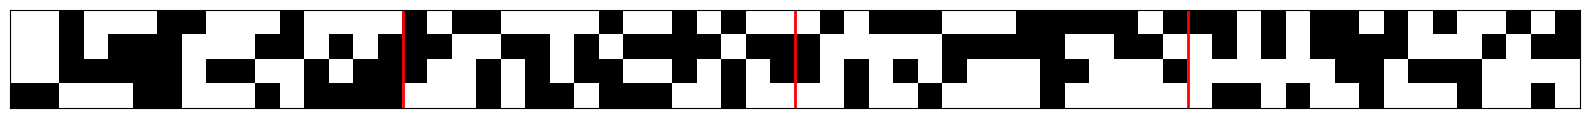

Figure 3. Rectangular 4 × 64 binary ribbon produced from the hash: 0x778b910ebb5c35318de2d1792558d2d99e3ea69ddc0aecdae47c7c81cba3de5c



In [178]:
base_hash.draw_binary_grid_from_hex(my_hash)
print(f'Figure 3. Rectangular 4 × 64 binary ribbon produced from the hash: {my_hash}\n')

### ▸ Circular Mandala

Below is the function `base_hash.draw_mandala(my_hash)`, which generates a circular mandala based on the principles described above. The linear ribbon displays the hash “as is,” while the mandala represents the same sequence of bits folded into a circle of 64 sectors and 4 layers. This transformation reveals the symmetry and rhythm hidden in the 256-bit number while maintaining strict determinism: one hash → one form.

* The 64 sectors are arranged **clockwise**, starting at the 12 o’clock position. A red radial line highlights the starting point.
* In each sector, the concentric cells from center to outer edge represent bits `b0 → b1 → b2 → b3`.
* White = 1 (*yáng*), black = 0 (*yīn*).
* The original hash is shown in the center, split into 4 lines × 16 characters — making it easy to match text to visual.

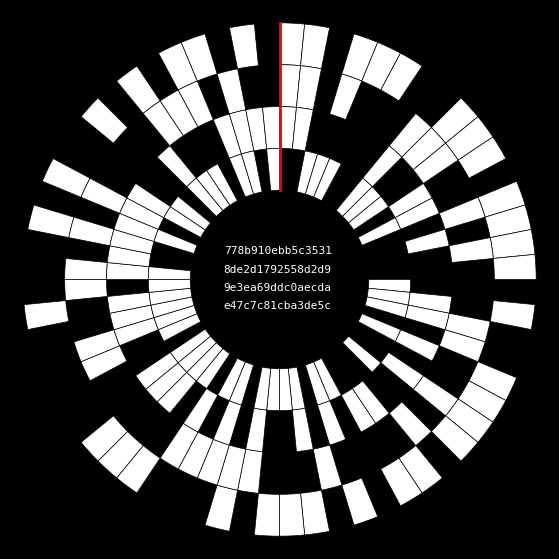

Figure 4. Circular mandala generated from the hash: 0x778b910ebb5c35318de2d1792558d2d99e3ea69ddc0aecdae47c7c81cba3de5c



In [182]:
base_hash.draw_mandala(my_hash, show_radial_line=True)
print(f'Figure 4. Circular mandala generated from the hash: {my_hash}\n')

#### ▸ Addresses as Hashes (160 bit)

In addition to 256-bit hashes, **HashCanon** can also transform **Ethereum addresses** — wallet or smart contract addresses — into mandalas. Visually, these are 40 hex characters; in essence, they represent a truncated fragment of a Keccak-256 hash, totaling **160 bits**.

Since `base_hash.draw_mandala()` accepts any length divisible by 4, for an address we simply specify `sectors = 40`:

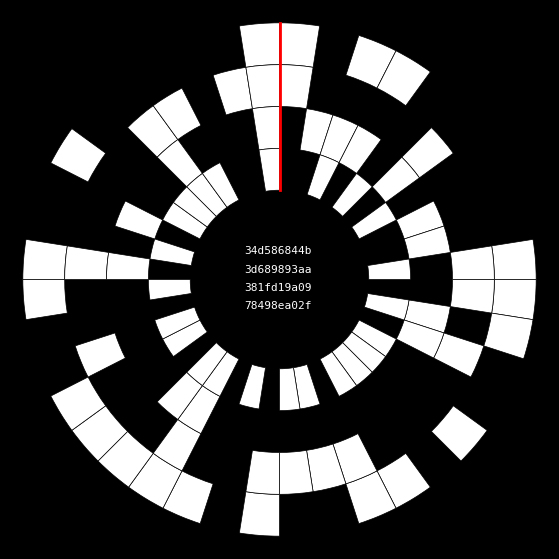

Figure 5. Circular mandala generated from the hash: 0x34d586844b3d689893aa381fd19a0978498ea02f



In [183]:
my_hash_160 = base_hash.generate_random_hash(bits=160)
base_hash.draw_mandala(my_hash_160, show_radial_line=True)
print(f'Figure 5. Circular mandala generated from the hash: {my_hash_160}\n')

The algorithm remains the same: each hex character produces four concentric cells, so the address appears as **40 radial sectors × 4 rings**. This allows any on-chain object — whether a wallet, contract, or NFT — to be “signed” with a mandala, while preserving HashCanon’s core principle: **one hash → one unique form**.

## 4. Features of Order

This section explores properties inherent in the circular mandalas that reveal structural order. These patterns are not imposed externally; they emerge spontaneously from the discrete entropy of the hash.

### 4.1 Balanced Mandala

A hash of *even* length **n** bits is called **balanced** when it contains exactly **n/2** ones and **n/2** zeros.

*Example A* For a **256-bit** hash, “balanced” means 128 ones and 128 zeros. In a sample of **10,000 randomly generated 256-bit hashes** produced with `secrets.token_hex(32)`, such mandalas appeared in **≈5%** of cases.

*Example B* For a **160-bit** hash (e.g., an Ethereum address), balance requires 80 ones and 80 zeros. The theoretical probability is **≈6%**, which matches the empirical share in a **10,000-hash** sample.

These numbers show that perfectly balanced mandalas are statistically rare, yet they emerge naturally from pure entropy.

Below are examples of balanced mandalas derived from both 256-bit and 160-bit hashes.

#### Balanced 256-bit Hash

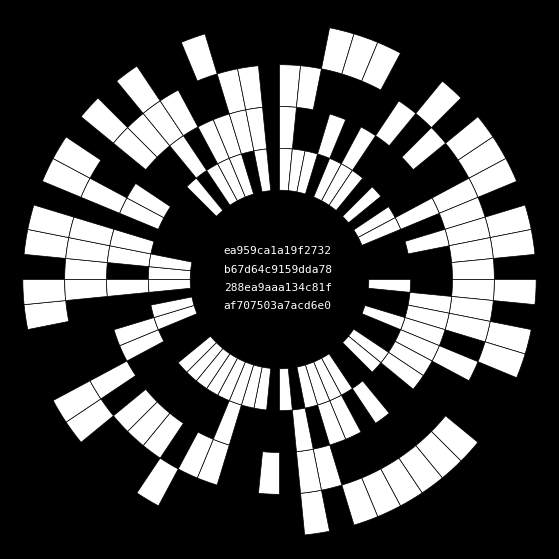

Figure 6. Balanced mandala from a 256-bit hash: 0xea959ca1a19f2732b67d64c9159dda78288ea9aaa134c81faf707503a7acd6e0



In [184]:
balanced_hash_256 = base_hash.generate_balanced_hash()
base_hash.draw_mandala(balanced_hash_256)
print(f'Figure 6. Balanced mandala from a 256-bit hash: {balanced_hash_256}\n')

In [185]:
print(
    "Zero/one ratio for the sample 256-bit hex string "
    f'"{balanced_hash_256}" = {base_hash.bit_ratio(balanced_hash_256)}'
)
print("(For a balanced hash, this ratio should equal 1.00)")
print(f"Balance check → is_balanced: {base_hash.is_balanced(balanced_hash_256)}\n")

Zero/one ratio for the sample 256-bit hex string "0xea959ca1a19f2732b67d64c9159dda78288ea9aaa134c81faf707503a7acd6e0" = 1.00
(For a balanced hash, this ratio should equal 1.00)
Balance check → is_balanced: True



#### Balanced 160-bit Hash

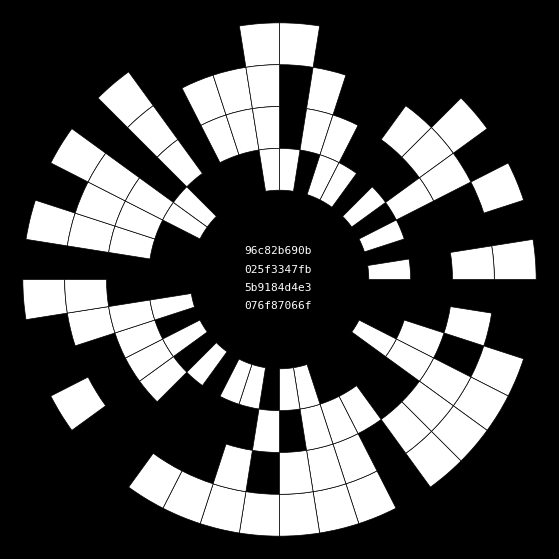

Figure 7. Balanced mandala from 160-bit hash: 0x96c82b690b025f3347fb5b9184d4e3076f87066f



In [186]:
balanced_hash_160 = base_hash.generate_balanced_hash(bits=160)
base_hash.draw_mandala(balanced_hash_160)
print(f'Figure 7. Balanced mandala from 160-bit hash: {balanced_hash_160}\n')

In [187]:
print(
    "Zero/one ratio for the sample 160-bit hex string "
    f'"{balanced_hash_160}" = {base_hash.bit_ratio(balanced_hash_160)}'
)
print("(For a balanced hash, this ratio should equal 1.00)")
print(f"Balance check → is_balanced: {base_hash.is_balanced(balanced_hash_160)}\n")

Zero/one ratio for the sample 160-bit hex string "0x96c82b690b025f3347fb5b9184d4e3076f87066f" = 1.00
(For a balanced hash, this ratio should equal 1.00)
Balance check → is_balanced: True



#### Theoretical probability

For a random binary string of even length (n), the chance of being perfectly balanced is
[
P ;=; \frac{\binom{n}{n/2}}{2^{n}}.
]

* **256 bits:** (P \approx 4.98%)
* **160 bits** (Ethereum addresses): (P \approx 6.30%)

Thus, perfectly balanced mandalas are rare yet statistically inevitable—an equilibrium that emerges naturally from randomness.

### 4.2 Passages and Sealed Structures in the Mandala

Most mandalas exhibit one or more **passages** — continuous paths from the inner ring to the outer ring formed entirely by zeros (black cells). These passages can be interpreted as escape routes through the labyrinth that a hypothetical observer could follow outward.

Each passage is **isolated by impassable walls of ones** (white cells), which break connectivity between paths and prevent crossovers.

A **sealed mandala** is a special case where none of the inner-ring cells provide any route to the outside. No passage connects the center to the edge — even indirectly. It is essentially an *airtight labyrinth*, completely enclosed by “white walls”.

Such structures are exceedingly rare: out of **10,000** randomly generated 256-bit hashes (via `secrets.token_hex(32)`), only about **0.07%** (7 out of 10,000) resulted in sealed mandalas.

#### 4.2.1 Single-Passage Hash

As an example, consider mandalas with exactly one passage:

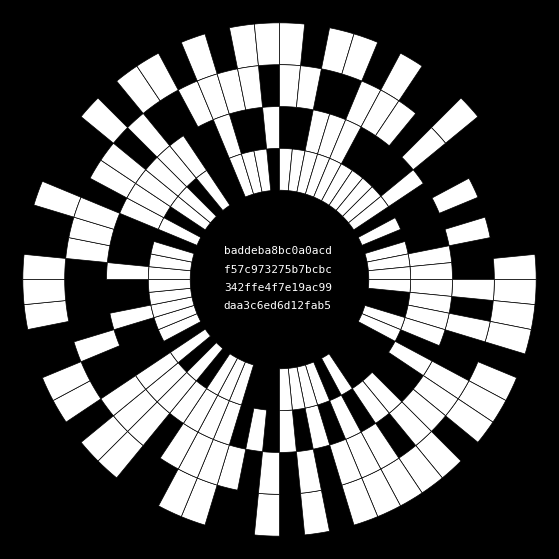

Figure 8. Single-passage mandala from 256-bit hash: 0xbaddeba8bc0a0acdf57c973275b7bcbc342ffe4f7e19ac99daa3c6ed6d12fab5



In [118]:
single_passage_hash_256 = base_hash.generate_hash_with_passages(target_passages=1)
base_hash.draw_mandala(single_passage_hash_256)
print(f'Figure 8. Single-passage mandala from 256-bit hash: {single_passage_hash_256}\n')

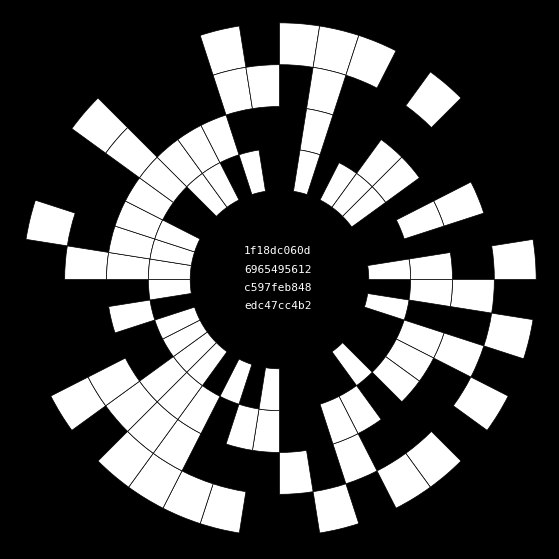

Figure 9. Single-passage mandala from 160-bit hash: 0x1f18dc060d6965495612c597feb848edc47cc4b2



In [120]:
single_passage_hash_160 = base_hash.generate_hash_with_passages(target_passages=1, bits=160)
base_hash.draw_mandala(single_passage_hash_160)
print(f'Figure 9. Single-passage mandala from 160-bit hash: {single_passage_hash_160}\n')

#### 4.2.2 Determining the Number of Passages in a Mandala Generated from a Random Hash

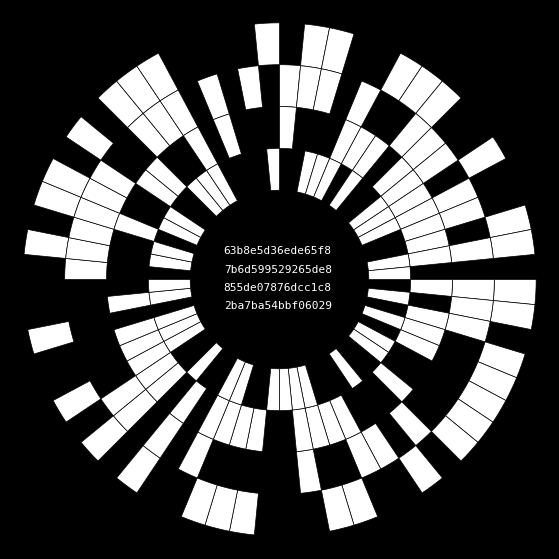

Figure 10. Mandala with 4 passages generated from a random 256-bit hash



In [188]:
random_hash_256 = base_hash.generate_random_hash()
base_hash.draw_mandala(random_hash_256)
print(f'Figure 10. Mandala with {base_hash.count_unique_passages(random_hash_256)} passages generated from a random 256-bit hash\n')

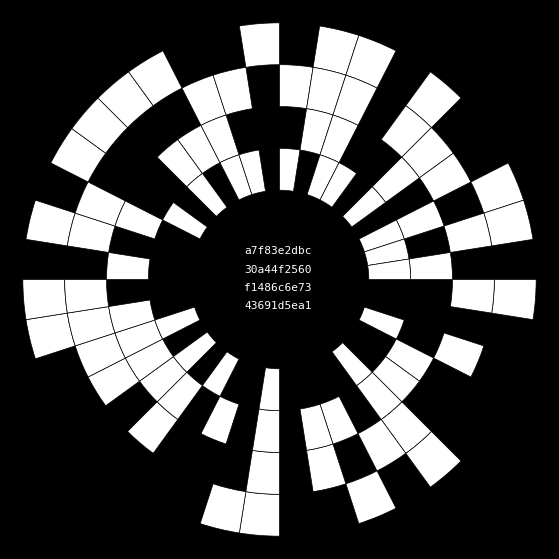

Figure 11. Mandala with 4 passages generated from a random 160-bit hash



In [4]:
random_hash_160 = base_hash.generate_random_hash(bits=160)
base_hash.draw_mandala(random_hash_160)
print(f'Figure 11. Mandala with {base_hash.count_unique_passages(random_hash_160)} passages generated from a random 160-bit hash\n')

#### 4.2.3 Sealed Mandala
Below are examples of *sealed* mandalas generated from 256-bit and 160-bit hashes, respectively:

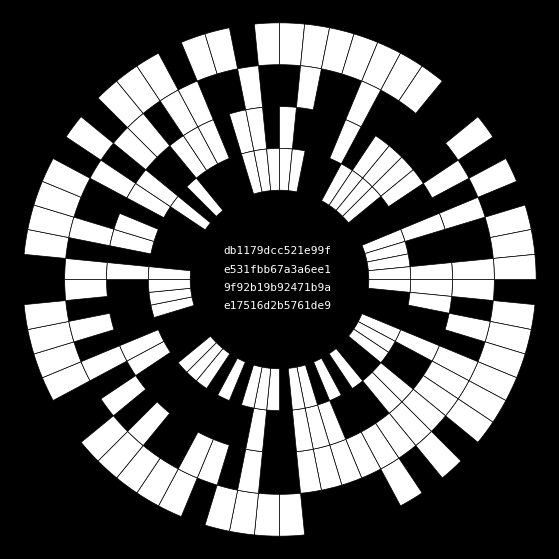

Figure 12. Sealed Mandala, generated from a random 256-bit hash: "0xdb1179dcc521e99fe531fbb67a3a6ee19f92b19b92471b9ae17516d2b5761de9"



In [123]:
sealed_hash_256 = base_hash.generate_hash_with_passages(target_passages=0)
base_hash.draw_mandala(sealed_hash_256)
print(f'Figure 12. Sealed Mandala, generated from a random 256-bit hash: "{sealed_hash_256}"\n')

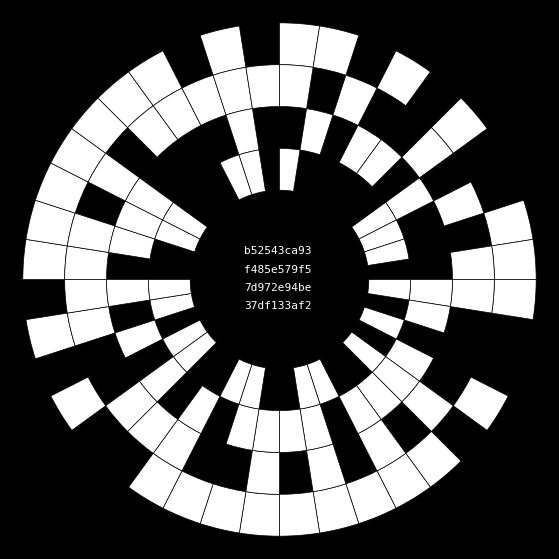

Figure 13. Sealed Mandala, generated from a random 160-bit hash: "0xb52543ca93f485e579f57d972e94be37df133af2"



In [124]:
sealed_hash_160 = base_hash.generate_hash_with_passages(target_passages=0, bits=160)
base_hash.draw_mandala(sealed_hash_160)
print(f'Figure 13. Sealed Mandala, generated from a random 160-bit hash: "{sealed_hash_160}"\n')

#### 4.2.4 Distribution of Passage Counts

This section examines the statistical distribution of **radial passage** counts in mandalas derived from random hashes. A passage is a connected path of black (0-bit) cells that leads from the inner ring to the outer ring. By generating large batches of hashes and counting the number of **unique** passages in each mandala, we can see how often **sealed** (0 passages), **single-path** (1 passage), or **highly porous** (many passages) structures occur.

**Histograms 1** and **2** present the passage-count distributions for **256-bit** and **160-bit** hashes, respectively.

In [125]:
COLOR_256 = "skyblue"
COLOR_160 = "lightcoral"

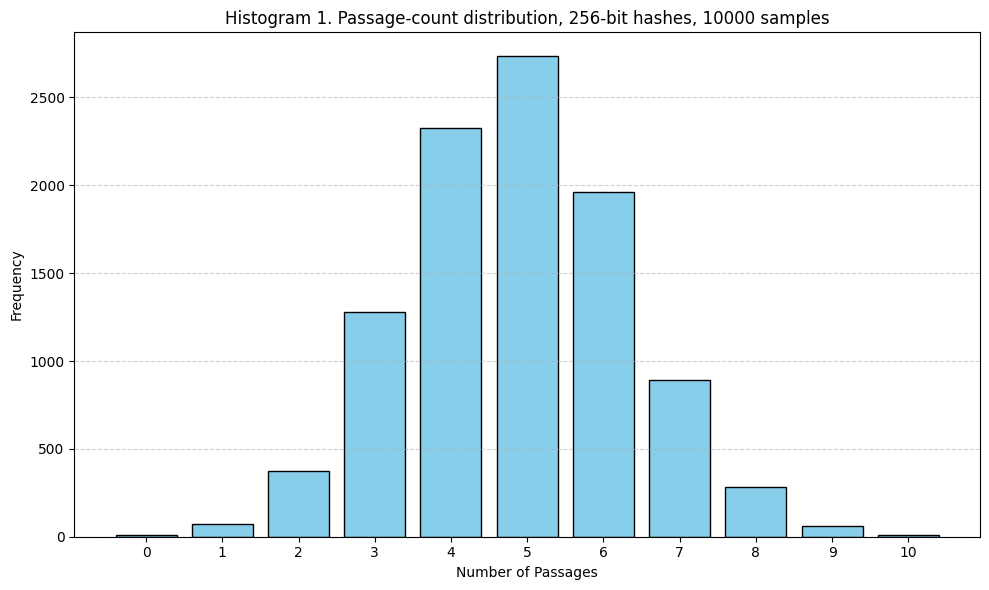

Counter({5: 2734, 4: 2327, 6: 1963, 3: 1281, 7: 893, 2: 375, 8: 281, 1: 70, 9: 59, 10: 10, 0: 7})


In [205]:
# 256-bit sample
sample_size = 10_000
bit_length = 256
distribution = base_hash.passage_distribution(sample_size, bits=bit_length)
counter = Counter(distribution)

# Plotting the histogram
df = pd.DataFrame.from_dict(counter, orient='index').sort_index()
df.columns = ['Frequency']
df.index.name = 'Number of Passages'

plt.figure(figsize=(10, 6))
plt.bar(df.index, df['Frequency'], color=COLOR_256, edgecolor='black')
plt.title(f"Histogram 1. Passage-count distribution, 256-bit hashes, {sample_size} samples")
plt.xlabel("Number of Passages")
plt.ylabel("Frequency")
plt.xticks(range(min(df.index), max(df.index)+1))
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
print(counter)

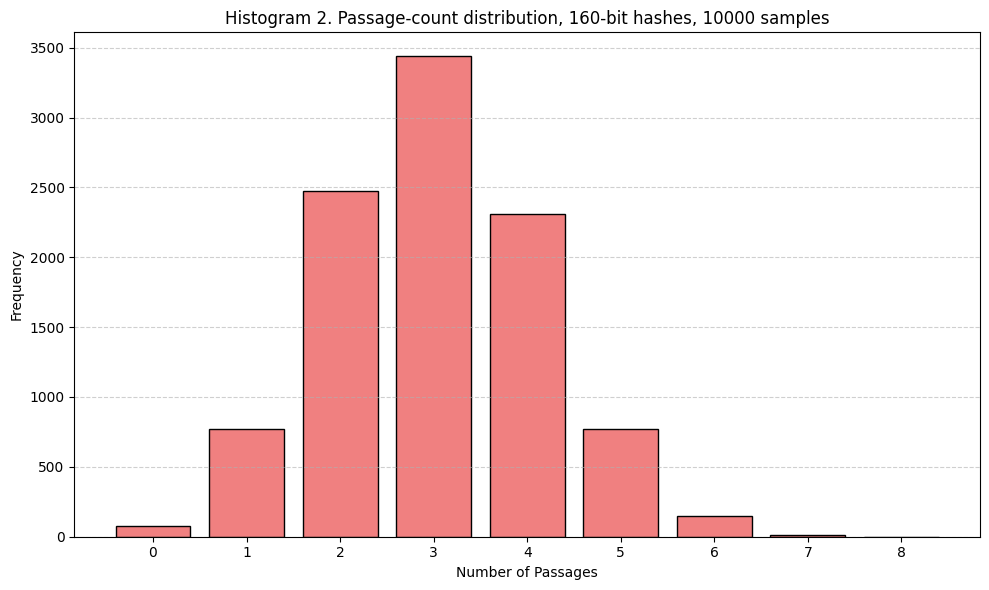

Counter({3: 3438, 2: 2472, 4: 2312, 1: 773, 5: 770, 6: 145, 0: 80, 7: 9, 8: 1})


In [206]:
# 160-bit sample
sample_size = 10_000
bit_length = 160
distribution = base_hash.passage_distribution(sample_size, bits=bit_length)
counter = Counter(distribution)

# Plotting the histogram
df = pd.DataFrame.from_dict(counter, orient='index').sort_index()
df.columns = ['Frequency']
df.index.name = 'Number of Passages'

plt.figure(figsize=(10, 6))
plt.bar(df.index, df['Frequency'], color=COLOR_160, edgecolor='black')
plt.title(f"Histogram 2. Passage-count distribution, 160-bit hashes, {sample_size} samples")
plt.xlabel("Number of Passages")
plt.ylabel("Frequency")
plt.xticks(range(min(df.index), max(df.index)+1))
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
print(counter)

### 4.3 Symmetries (Circular Palindromes)

**Symmetries, in short.**
“Symmetries” are **circular palindromes** present **simultaneously on all four rings**. We detect **all** palindrome arcs of length ≥ 2. Visualization: red radial lines mark **boundaries**; semi-transparent **gray** sectors show all palindromes; semi-transparent **red** sectors highlight the **maximal** ones.

**Definition.**
In a mandala, a **symmetry** is a local mirror pattern along the circle: over a contiguous sector arc \([start, …, start+length−1]\) with wraparound, bits on **all four rings** read the same left-to-right and right-to-left. The **rank** of a palindrome equals its length in sectors.

**Selection.**
We enumerate all arcs of length ≥ 2 and keep only **maximal** ones (i.e., not contained inside a longer palindrome in the same circular sense).

**Visualization.**
Over the mandala we display:

1. **red radial lines** — palindrome boundaries;
2. **semi-transparent gray** sectors — all detected palindromes;
3. **semi-transparent red** sectors — only **maximal** palindromes.

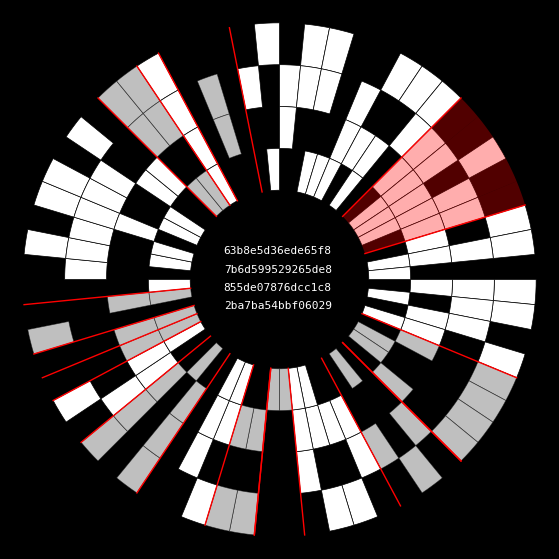

Figure 14. Symmetries overlay for a 256-bit hash: "0x63b8e5d36ede65f87b6d599529265de8855de07876dcc1c82ba7ba54bbf06029"



In [207]:
base_hash.draw_mandala(random_hash_256, symmetry_overlay_segments=True) 
print(f'Figure 14. Symmetries overlay for a 256-bit hash: "{random_hash_256}"\n')

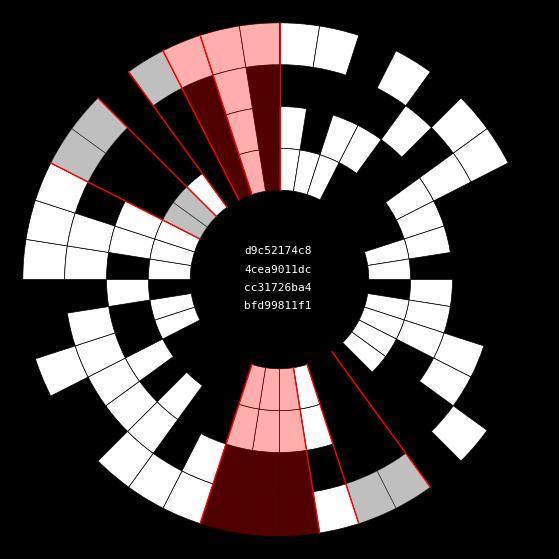

Figure 15. Symmetries overlay for a 160-bit hash: "0xd9c52174c84cea9011dccc31726ba4bfd99811f1"



In [240]:
base_hash.draw_mandala(random_hash_160, symmetry_overlay_segments=True) 
print(f'Figure 15. Symmetries overlay for a 160-bit hash: "{random_hash_160}"\n')

#### 4.3.1 Summary metric
**What it is:** a string like `9 total | Ranks: 2:3, 3:6` listing the **total** number of palindromes, then **ranks** (length in sectors) and their counts.

In [131]:
base_hash.symmetry_metric(random_hash_256)

'6 total | Ranks: 2:1, 3:4, 4:1'

In [132]:
base_hash.symmetry_metric(random_hash_160)

'5 total | Ranks: 2:3, 3:2'

#### 4.3.2 Symmetry list (positions and slices)
**What it is:** an array of tuples `(start, length, slice)` for **maximal** palindromes (wrap-aware), including the corresponding hexadecimal subsequence.

In [144]:
syms_256 = base_hash.find_symmetries(random_hash_256)
syms_256

[(3, 3, '161'),
 (5, 4, '1881'),
 (10, 3, '6a6'),
 (11, 3, 'a6a'),
 (24, 3, 'afa'),
 (26, 2, 'aa')]

In [5]:
syms_160 = base_hash.find_symmetries(random_hash_160)
syms_160

[(13, 2, '44'), (24, 3, '6c6'), (29, 3, '343'), (38, 3, 'a1a')]

#### 4.3.3 Rank aggregation

**What it is:** a dictionary `{rank: count}` — how many palindromes of each rank were found (e.g., `{2: 3, 3: 6}`).

In [146]:
base_hash.symmetry_ranks(syms_256) 

{2: 1, 3: 4, 4: 1}

In [147]:
base_hash.symmetry_ranks(syms_160) 

{2: 3, 3: 2}

#### 4.3.4 Overlay data

**What it is:** helper structures for overlay rendering:

* `boundaries`: pairs `(start, end)` — where to place red radial lines;
* `all_spans`: `(start, length)` — all palindromes (gray layer);
* `max_spans`: `(start, length)` — only maximal ones (red layer).

In [148]:
ov = base_hash.symmetry_overlay_segments(syms_256)
ov

{'boundaries': [(3, 6), (5, 9), (10, 13), (11, 14), (24, 27), (26, 28)],
 'all_spans': [(3, 3), (5, 4), (10, 3), (11, 3), (24, 3), (26, 2)],
 'max_spans': [(5, 4)]}

In [149]:
ov = base_hash.symmetry_overlay_segments(syms_160)
ov

{'boundaries': [(16, 18), (19, 22), (33, 35), (36, 38), (37, 0)],
 'all_spans': [(16, 2), (19, 3), (33, 2), (36, 2), (37, 3)],
 'max_spans': [(19, 3), (37, 3)]}

#### 4.3.5 Crown (maximum symmetry)

**What it is:** a tuple `(max_len, count, starts, slices)` summarizing the maximum rank, how many such arcs exist, their start indices, and text slices.

In [150]:
base_hash.crown_from_symmetries(syms_256)

(4, 1, [5], ['1881'])

In [6]:
base_hash.crown_from_symmetries(syms_160)

(3, 3, [24, 29, 38], ['6c6', '343', 'a1a'])

#### 4.3.6 Crown summary metric

**What it is:** a compact signature **`L:K`**, e.g., **`4:1`** (max symmetry length **L** and its occurrence count **K**). If absent — **`—`**.

In [152]:
base_hash.crown_metric(random_hash_256)

'4:1'

In [153]:
base_hash.crown_metric(random_hash_160)

'3:2'

**Crown slices.** In addition to the scalar crown metric `L:K` (max symmetry length `L` and its occurrence count `K`), it is often useful to extract the actual repeating motifs. `crown_slices(hash, bits)` returns the list of hex substrings corresponding to all max-length symmetries (the “crown”). The list includes **all occurrences** (not uniqued), in the scan order. These slices are wrap-aware (circular) and can be used for motif inspection, clustering, and provenance/debugging of the crown metric.

In [154]:
base_hash.crown_slices(random_hash_256)

['1881']

In [155]:
base_hash.crown_slices(random_hash_160)

['ccc', '1f1']

#### 4.3.7 Distribution of Symmetries

In this section we study the statistics of **local circular palindromes** (“symmetries”) in mandalas derived from random hashes. For each hash we compute:

* `total_symmetries` — the number of **maximal** palindromes;
* `max_rank` — the largest observed rank (length in sectors);
* `ranks` — rank frequencies (for summary tables).

We use **50,000**-hash samples for both 256- and 160-bit cases and then plot distribution histograms.

#### Dataset builder (N = 50,000)

In [199]:
# Build per-hash symmetry metrics for a given bit length
# Comments in English only
def build_symmetry_sample(n_samples: int, bits: int = 256) -> pd.DataFrame:
    records = []
    for _ in range(n_samples):
        hx = base_hash.generate_random_hash(bits=bits)
        syms = base_hash.find_symmetries(hx, bits=bits)
        total = len(syms)
        max_len = 0
        if syms:
            max_len = max(L for _, L, _ in syms)
        ranks = base_hash.symmetry_ranks(syms)  # dict {rank:length -> count}
        records.append({
            "hex": hx,
            "bits": bits,
            "total_symmetries": total,
            "max_rank": max_len,
            "ranks": ranks,
        })
    return pd.DataFrame.from_records(records)

# Generate two samples (keep sizes equal for comparability)
SAMPLE_SIZE = 50_000
df_sym_256 = build_symmetry_sample(SAMPLE_SIZE, bits=256)
df_sym_160 = build_symmetry_sample(SAMPLE_SIZE, bits=160)

In [200]:
df_sym_256.head(3)

,hex,bits,total_symmetries,max_rank,ranks
0,0x01230255fd3c425e35a056d97ae62d69bf410fa017b9...,256,1,2,{2: 1}
1,0x6c14f7997f6ed56e69f1d15a1fd4df4cd2f032b84548...,256,8,6,"{2: 1, 3: 3, 4: 1, 5: 2, 6: 1}"
2,0x09303b0dc4a34fcc268148b1cdb4e97213955b53528c...,256,8,3,"{2: 4, 3: 4}"


In [202]:
df_sym_160.head(3)

,hex,bits,total_symmetries,max_rank,ranks
0,0xe53aadc5b89c304395eff6a25f8f47e1d6bb66d8,160,5,4,"{2: 3, 3: 1, 4: 1}"
1,0x79491d554c8e41ae27fd0a101e4120372bda4a6c,160,4,3,"{2: 1, 3: 3}"
2,0x14bbfb8f5b06fb45c589364f57f505a00422db60,160,6,3,"{2: 3, 3: 3}"


#### Histogram 3 — Distribution of `total_symmetries` (256-bit)

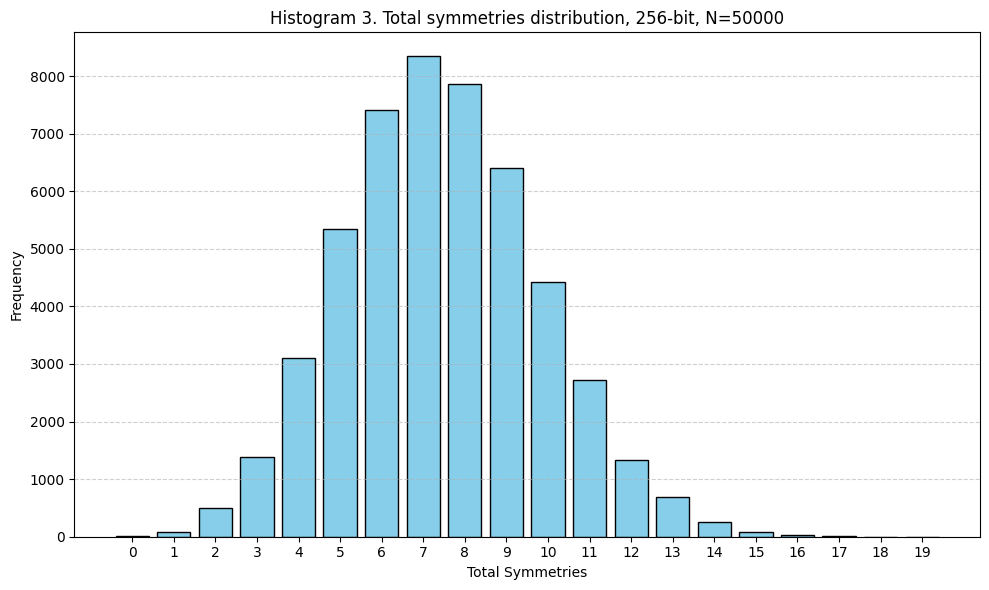

Counter({7: 8343,
         8: 7862,
         6: 7406,
         9: 6399,
         5: 5350,
         10: 4425,
         4: 3109,
         11: 2715,
         3: 1386,
         12: 1331,
         13: 686,
         2: 502,
         14: 259,
         1: 89,
         15: 84,
         16: 35,
         17: 11,
         0: 5,
         18: 2,
         19: 1})

In [209]:
counts_256 = Counter(df_sym_256["total_symmetries"].tolist())
df_h3 = pd.DataFrame.from_dict(counts_256, orient="index").sort_index()
df_h3.columns = ["Frequency"]
df_h3.index.name = "Total Symmetries"

plt.figure(figsize=(10, 6))
plt.bar(df_h3.index, df_h3["Frequency"], color=COLOR_256, edgecolor="black")
plt.title(f"Histogram 3. Total symmetries distribution, 256-bit, N={SAMPLE_SIZE}")
plt.xlabel("Total Symmetries")
plt.ylabel("Frequency")
plt.xticks(range(int(df_h3.index.min()), int(df_h3.index.max()) + 1))
plt.grid(True, axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

counts_256

#### Histogram 4 — Distribution of `total_symmetries` (160-bit)


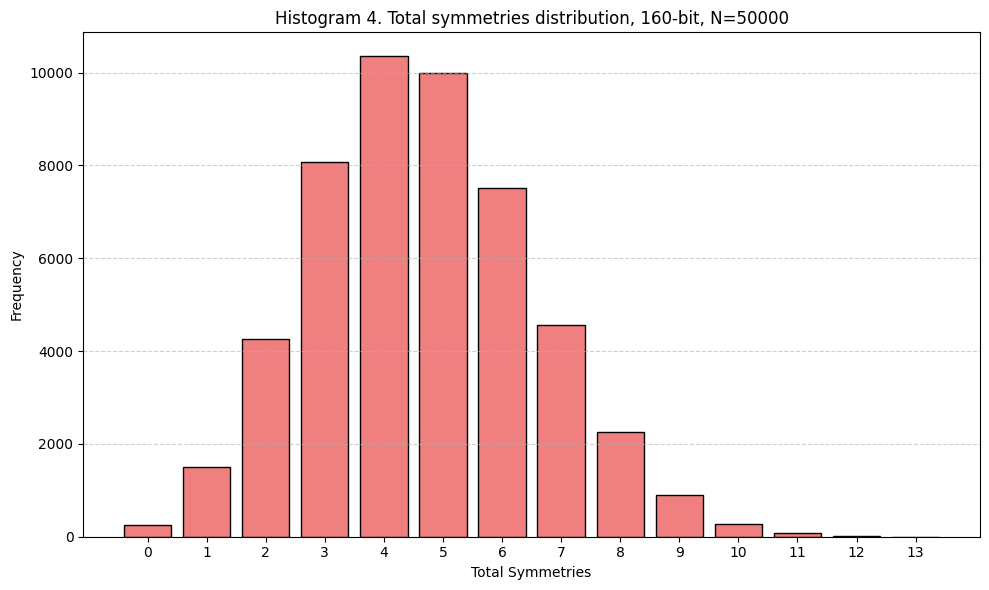

Counter({4: 10349,
         5: 9999,
         3: 8063,
         6: 7513,
         7: 4552,
         2: 4255,
         8: 2257,
         1: 1509,
         9: 893,
         10: 274,
         0: 244,
         11: 76,
         12: 15,
         13: 1})

In [210]:
counts_160 = Counter(df_sym_160["total_symmetries"].tolist())
df_h4 = pd.DataFrame.from_dict(counts_160, orient="index").sort_index()
df_h4.columns = ["Frequency"]
df_h4.index.name = "Total Symmetries"

plt.figure(figsize=(10, 6))
plt.bar(df_h4.index, df_h4["Frequency"], color=COLOR_160, edgecolor="black")
plt.title(f"Histogram 4. Total symmetries distribution, 160-bit, N={SAMPLE_SIZE}")
plt.xlabel("Total Symmetries")
plt.ylabel("Frequency")
plt.xticks(range(int(df_h4.index.min()), int(df_h4.index.max()) + 1))
plt.grid(True, axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

counts_160

#### Histogram 5 — Distribution of `max_rank` (256-bit)


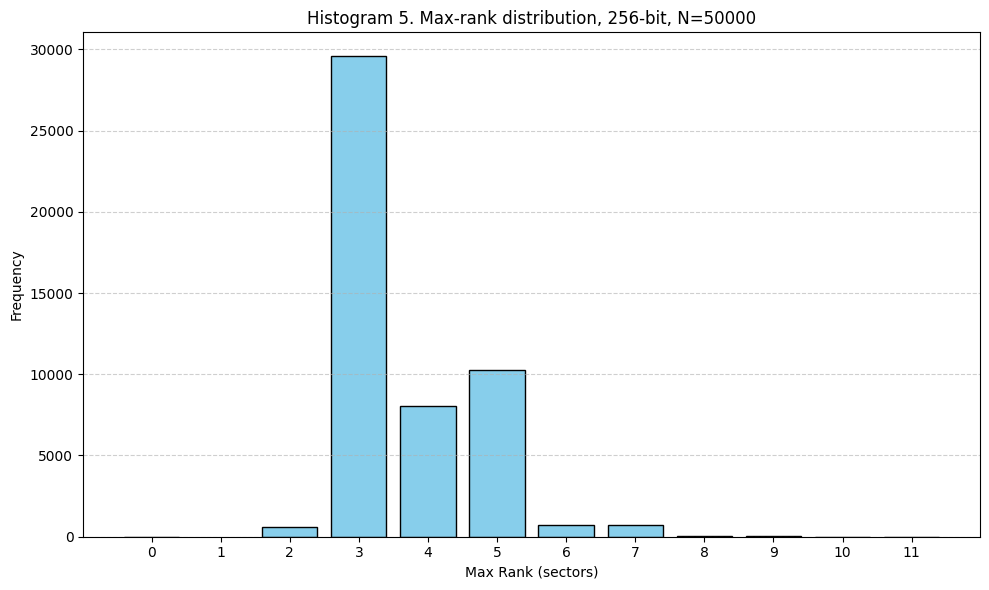

Counter({3: 29571,
         5: 10271,
         4: 8048,
         7: 713,
         6: 691,
         2: 593,
         9: 62,
         8: 43,
         0: 5,
         11: 2,
         10: 1})

In [211]:
mr_256 = Counter(df_sym_256["max_rank"].tolist())
df_h5 = pd.DataFrame.from_dict(mr_256, orient="index").sort_index()
df_h5.columns = ["Frequency"]
df_h5.index.name = "Max Rank (sectors)"

plt.figure(figsize=(10, 6))
plt.bar(df_h5.index, df_h5["Frequency"], color=COLOR_256, edgecolor="black")
plt.title(f"Histogram 5. Max-rank distribution, 256-bit, N={SAMPLE_SIZE}")
plt.xlabel("Max Rank (sectors)")
plt.ylabel("Frequency")
plt.xticks(range(int(df_h5.index.min()), int(df_h5.index.max()) + 1))
plt.grid(True, axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

mr_256

#### Histogram 6 — Distribution of `max_rank` (160-bit)


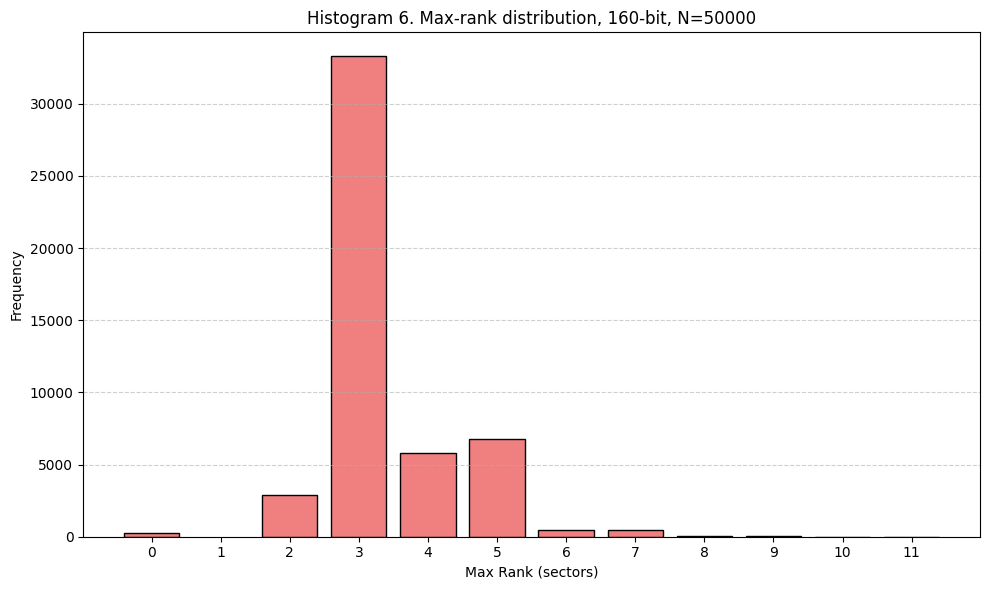

Counter({3: 33282,
         5: 6757,
         4: 5825,
         2: 2922,
         7: 450,
         6: 445,
         0: 244,
         9: 42,
         8: 26,
         11: 4,
         10: 3})

In [212]:
mr_160 = Counter(df_sym_160["max_rank"].tolist())
df_h6 = pd.DataFrame.from_dict(mr_160, orient="index").sort_index()
df_h6.columns = ["Frequency"]
df_h6.index.name = "Max Rank (sectors)"

plt.figure(figsize=(10, 6))
plt.bar(df_h6.index, df_h6["Frequency"], color=COLOR_160, edgecolor="black")
plt.title(f"Histogram 6. Max-rank distribution, 160-bit, N={SAMPLE_SIZE}")
plt.xlabel("Max Rank (sectors)")
plt.ylabel("Frequency")
plt.xticks(range(int(df_h6.index.min()), int(df_h6.index.max()) + 1))
plt.grid(True, axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

mr_160

#### Summary table by ranks — average rank frequencies

In [213]:
def aggregate_rank_frequencies(df: pd.DataFrame) -> pd.DataFrame:
    agg: Counter = Counter()
    for d in df["ranks"].tolist():
        for k, v in (d or {}).items():
            agg[k] += v
    # convert to per-hash average
    total = len(df)
    rows = [(rank, agg[rank] / total) for rank in sorted(agg)]
    return pd.DataFrame(rows, columns=["rank", "mean_count_per_hash"])

rank_freq_256 = aggregate_rank_frequencies(df_sym_256)
rank_freq_160 = aggregate_rank_frequencies(df_sym_160)

rank_freq_256.head(10), rank_freq_160.head(10)

(   rank  mean_count_per_hash
 0     2              3.26258
 1     3              3.68392
 2     4              0.23482
 3     5              0.23702
 4     6              0.01414
 5     7              0.01444
 6     8              0.00086
 7     9              0.00124
 8    10              0.00002
 9    11              0.00004,
    rank  mean_count_per_hash
 0     2              2.02822
 1     3              2.30724
 2     4              0.14462
 3     5              0.14836
 4     6              0.00906
 5     7              0.00906
 6     8              0.00052
 7     9              0.00084
 8    10              0.00006
 9    11              0.00008)

# 5 Simulated Joint Distribution

In this section, we simulate a random collection of **10,000 mandalas** derived from uniformly distributed 256-bit hashes. 

For each hash, we extract two structural features:

* `num_passages`: the number of radial escape paths (distinct zero-connected routes from center to edge);
* `is_balanced`: a boolean flag indicating whether the hash contains exactly **128** zeros and **128** ones (a **balanced mandala**).

The following table presents the raw dataset used in this simulation.
Each row corresponds to a single hash and its computed properties, which form the basis for the aggregated analysis in the next section. Note that, with a sample of this size, extreme outcomes (e.g., *sealed* mandalas with `num_passages = 0`) may appear a handful of times—or not at all—purely due to sampling variability.


In [193]:
df = base_hash.generate_hash_dataframe(n = 10_000, bits = 256)
display(
    df.head().style
      .set_caption("Table A. Raw sample: hash, balance flag, passage count")
)

,hash,is_balanced,num_passages
0,0x1094dd1dd4391d4c7b66e71be022bab8c998b7605ec6721f892c1401c0067c46,False,6
1,0x2e8b8ca400bf76c2b297600795458c5d80d8f1791f5f313abc46294c1f5a63d2,False,4
2,0x3110d7fe1a88482a0b90e771020fe217d3c28138bcf0399db19baf07dbe67165,False,6
3,0xd6ecce28a327c31d0b2cd98d050eb741d5e3fbc2143cfe77698a788fb93a1d8a,False,6
4,0xf6cd914b4eb46cd6d6d09cdbf016c224684c235d69a18164bbf7c417fad1c89a,True,6


### 5.1 Aggregations: Passages × Balance

The table below summarizes the simulation results:

* `total_hashes` — number of hashes observed for each value of `num_passages`;
* `balanced_count` — how many of those hashes also satisfy the **balanced mandala** criterion.

This aggregation estimates how often passage structure and bit balance co-occur in purely random data.

In [194]:
# Group by number of passes with column reordering
aggregation = (
    df.groupby("num_passages")
      .agg(
          total_hashes=("hash", "count"),
          balanced_count=("is_balanced", "sum")
      )
      .reset_index()[["num_passages", "total_hashes", "balanced_count"]]
)

# Print the result
display(
    aggregation.style
        .set_caption(
            "Table B. Total hashes and balanced-hash counts per passage class"
        )
)

,num_passages,total_hashes,balanced_count
0,0,3,0
1,1,82,1
2,2,376,13
3,3,1270,58
4,4,2291,108
5,5,2746,156
6,6,1994,101
7,7,911,42
8,8,265,12
9,9,58,0


#### Commentary

* The passage-count distribution is centered around **4–6 passages**, reflecting the typical structural openness of a mandala.
* **Balanced mandalas** occur more frequently within this central range.
* **Sealed** mandalas (`num_passages = 0`) remain extremely rare.
* **Very porous** mandalas (`num_passages ≥ 9`) constitute the thin upper tail of the distribution.

These results quantify the structural expectations for hash-based mandalas and highlight how infrequently extreme configurations occur.

### 5.2 Symmetry metrics on the same sample (N = 8,192; 256-bit)

In this subsection we augment the same `df` with **Symmetries** metrics and build summaries that combine **Passages** and **Symmetries**.

In [195]:
# Compute symmetry metrics for one 256-bit hash
def _symmetry_metrics_256(hx: str):
    syms = base_hash.find_symmetries(hx, bits=256)
    total = len(syms)
    max_len = max((L for _, L, _ in syms), default=0)
    crown = base_hash.crown_metric(hx, bits=256)   # e.g. "4:1" or "—"
    ranks = base_hash.symmetry_ranks(syms)         # dict {rank: count}
    return total, max_len, crown, ranks

# Augment the existing df (hash, num_passages, is_balanced) with symmetry metrics
def add_symmetry_columns_256(df_in: pd.DataFrame) -> pd.DataFrame:
    totals, max_ranks, crowns, ranks_list = [], [], [], []
    for hx in df_in["hash"].tolist():
        t, mr, cr, rk = _symmetry_metrics_256(hx)
        totals.append(t)
        max_ranks.append(mr)
        crowns.append(cr)
        ranks_list.append(rk)
    out = df_in.copy()
    out["total_symmetries"] = totals
    out["max_rank"] = max_ranks
    out["crown"] = crowns
    out["ranks"] = ranks_list
    return out

df_aug = add_symmetry_columns_256(df)

display(
    df_aug.head().style.set_caption("Table A+. Raw sample augmented with symmetry metrics")
)

,hash,is_balanced,num_passages,total_symmetries,max_rank,crown,ranks
0,0x1094dd1dd4391d4c7b66e71be022bab8c998b7605ec6721f892c1401c0067c46,False,6,6,7,7:1,"{2: 4, 3: 1, 7: 1}"
1,0x2e8b8ca400bf76c2b297600795458c5d80d8f1791f5f313abc46294c1f5a63d2,False,4,8,3,3:5,"{2: 3, 3: 5}"
2,0x3110d7fe1a88482a0b90e771020fe217d3c28138bcf0399db19baf07dbe67165,False,6,6,3,3:2,"{2: 4, 3: 2}"
3,0xd6ecce28a327c31d0b2cd98d050eb741d5e3fbc2143cfe77698a788fb93a1d8a,False,6,4,4,4:1,"{2: 2, 3: 1, 4: 1}"
4,0xf6cd914b4eb46cd6d6d09cdbf016c224684c235d69a18164bbf7c417fad1c89a,True,6,5,5,5:1,"{2: 2, 3: 2, 5: 1}"


#### 5.2.1 Passages × Symmetries (means, medians, tails)
We extend **Table B**: in addition to grouping by `num_passages`, we add symmetry means/medians and the share of “strong” symmetries (`max_rank ≥ 4`).

In [196]:
agg_passages = (
    df_aug.groupby("num_passages")
          .agg(
              total_hashes=("hash", "count"),
              balanced_count=("is_balanced", "sum"),
              sym_total_mean=("total_symmetries", "mean"),
              sym_total_median=("total_symmetries", "median"),
              sym_total_p95=("total_symmetries", lambda s: np.percentile(s, 95)),
              max_rank_mean=("max_rank", "mean"),
              max_rank_median=("max_rank", "median"),
              share_maxrank_ge4=("max_rank", lambda s: (s >= 4).mean()),
          )
          .reset_index()
          .sort_values("num_passages")
)

display(
    agg_passages.style.format({
        "sym_total_mean": "{:.2f}",
        "sym_total_median": "{:.2f}",
        "sym_total_p95": "{:.2f}",
        "max_rank_mean": "{:.2f}",
        "max_rank_median": "{:.2f}",
        "share_maxrank_ge4": "{:.2%}",
    }).set_caption("Table B+. Passages × symmetry stats (256-bit, N=8,192)")
)

,num_passages,total_hashes,balanced_count,sym_total_mean,sym_total_median,sym_total_p95,max_rank_mean,max_rank_median,share_maxrank_ge4
0,0,3,0,9.00,10.00,10.90,4.00,3.00,33.33%
1,1,82,1,8.39,8.00,13.00,3.67,3.00,36.59%
2,2,376,13,8.14,8.00,12.00,3.84,3.00,46.54%
3,3,1270,58,7.87,8.00,12.00,3.73,3.00,43.31%
4,4,2291,108,7.66,8.00,12.00,3.70,3.00,41.16%
5,5,2746,156,7.41,7.00,11.00,3.65,3.00,39.11%
6,6,1994,101,7.19,7.00,11.00,3.68,3.00,39.72%
7,7,911,42,6.83,7.00,11.00,3.57,3.00,34.14%
8,8,265,12,6.55,7.00,10.00,3.57,3.00,33.58%
9,9,58,0,6.45,6.00,11.00,3.53,3.00,31.03%


#### 5.2.2 Balanced vs Non-balanced: Symmetries & Passages

We compare symmetry patterns in balanced and non-balanced mandalas within the same sample.

In [197]:
agg_bal = (
    df_aug.groupby("is_balanced")
          .agg(
              total_hashes=("hash", "count"),
              sym_total_mean=("total_symmetries", "mean"),
              sym_total_median=("total_symmetries", "median"),
              max_rank_mean=("max_rank", "mean"),
              share_maxrank_ge4=("max_rank", lambda s: (s >= 4).mean()),
              passages_mean=("num_passages", "mean"),
            )
          .reset_index()
)

display(
    agg_bal.style.format({
        "sym_total_mean": "{:.2f}",
        "sym_total_median": "{:.2f}",
        "max_rank_mean": "{:.2f}",
        "share_maxrank_ge4": "{:.2%}",
        "passages_mean": "{:.2f}",
    }).set_caption("Table C. Balanced vs Non-balanced: symmetry & passages (256-bit)")
)

,is_balanced,total_hashes,sym_total_mean,sym_total_median,max_rank_mean,share_maxrank_ge4,passages_mean
0,False,9509,7.43,7.00,3.67,39.81%,4.85
1,True,491,7.46,7.00,3.71,40.33%,4.91


#### 5.2.3 Contingency: `num_passages × max_rank`

Contingency matrix for heatmaps and rarity rules.

In [175]:
pivot_pm = pd.pivot_table(
    df_aug,
    index="num_passages",
    columns="max_rank",
    values="hash",
    aggfunc="count",
    fill_value=0,
)

display(
    pivot_pm.style.set_caption(
        "Table D. Contingency: num_passages × max_rank (counts; 256-bit sample)"
    )
)

max_rank,0,2,3,4,5,6,7,8,9
num_passages,,,,,,,,,
0,0,0,4,1,0,0,0,0,0
1,0,1,31,7,20,3,0,0,0
2,1,1,172,70,66,5,6,0,1
3,0,9,605,182,237,17,23,0,0
4,0,20,1099,340,424,36,18,0,2
5,0,30,1250,374,446,29,35,1,2
6,0,26,973,230,337,14,24,1,0
7,0,7,440,110,152,9,6,1,1
8,0,5,163,25,42,2,2,0,0


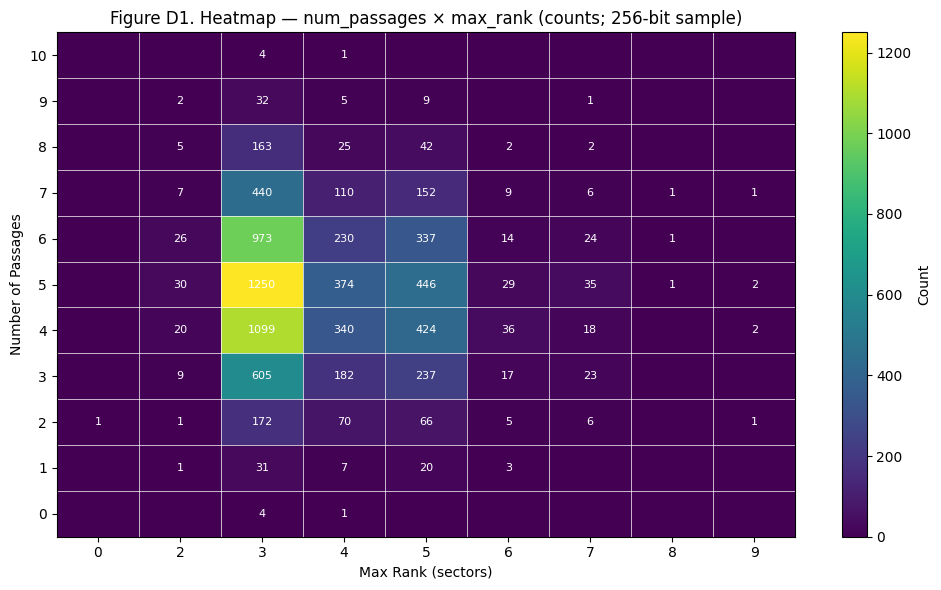

In [198]:
# Prepare matrix and axes labels
mat = pivot_pm.values
x_labels = pivot_pm.columns.to_list()      # max_rank
y_labels = pivot_pm.index.to_list()        # num_passages

fig, ax = plt.subplots(figsize=(10, 6))

# Heatmap
im = ax.imshow(mat, aspect="auto", cmap="viridis", origin="lower")

# Colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Count")

# Ticks and labels
ax.set_xticks(np.arange(len(x_labels)))
ax.set_yticks(np.arange(len(y_labels)))
ax.set_xticklabels(x_labels)
ax.set_yticklabels(y_labels)

# Axis titles
ax.set_xlabel("Max Rank (sectors)")
ax.set_ylabel("Number of Passages")
ax.set_title("Figure D1. Heatmap — num_passages × max_rank (counts; 256-bit sample)")

# Grid-like separation (optional)
ax.set_xticks(np.arange(-0.5, len(x_labels), 1), minor=True)
ax.set_yticks(np.arange(-0.5, len(y_labels), 1), minor=True)
ax.grid(which="minor", color="white", linestyle="-", linewidth=0.5)
ax.tick_params(which="minor", bottom=False, left=False)

# Annotate cells with counts
for i in range(mat.shape[0]):
    for j in range(mat.shape[1]):
        val = int(mat[i, j])
        if val > 0:
            ax.text(j, i, str(val), ha="center", va="center", color="white", fontsize=8)

plt.tight_layout()
plt.show()


## Community & Support

Questions, ideas or bug reports?  
Open a thread in [**HashCanon Discussions**](https://github.com/HashCanon/hashcanon.github.io/discussions) and let’s talk!

For a detailed list of HashCanon contacts and resources, see the page [**Contacts and Resources**](https://hashcanon.github.io/resources/).

For a live generator and examples, see the [**HashCanon Generator**](https://hashcanon.github.io/generator/)